<a href="https://colab.research.google.com/github/pc-piyush/CAI5724/blob/master/CAI5724_PC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Digital Twin Framework for CDC Diabetes Database**

Digital Twin (DT) is an in-silico representation of a patient that enables dynamic simulation and prediction of health trajectory. They are built with an input of multi-modal, continuous, time-series factors from patient’s clinical, genetic and molecular data, frequently supplemented by environmental and social determinants to provide a holistic view of patient health.

The model is continuously updated with any new measurement and it updates the twin's internal state. The DT can then be posed 'what-if' cases and model runs simulations to predict outcomes and health trajectory.

In training, the predicted outcomes are compared to clinical outcomes- to calibrate and validate the Digital Twin.


In [ ]:
# !pip3 install -r requirements.txt
!pip3 install streamlit pandas numpy matplotlib seaborn scikit-learn xgboost lightgbm ucimlrepo

In [1]:
import streamlit as st
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, precision_recall_curve, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity, manhattan_distances
from ucimlrepo import fetch_ucirepo
import warnings
warnings.filterwarnings("ignore")

ModuleNotFoundError: No module named 'streamlit'

In [ ]:
def load_default_data():
    # fetch dataset using ucimlrepo; fallback to direct CSV if unavailable
    try:
        repo = fetch_ucirepo(id=891)
        # repo.data.features is a DataFrame, repo.data.targets is array-like
        df = repo.data.features.copy()
        df['Diabetes_binary'] = repo.data.targets
        return df
    except Exception:
        url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00529/diabetes_binary_5050split_health_indicators_BRFSS2015.csv"
        return pd.read_csv(url)

def build_preprocessor(X):
    num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
    cat_cols = [c for c in X.columns if c not in num_cols]
    # OneHotEncoder(sparse=False) to get feature names easily
    preproc = ColumnTransformer([
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ], remainder="drop")
    preproc.fit(X)
    # create feature names
    cat_feature_names = []
    if len(cat_cols) > 0:
        try:
            cat_feature_names = preproc.named_transformers_['cat'].get_feature_names_out(cat_cols)
        except Exception:
            # older sklearn versions:
            cat_feature_names = preproc.named_transformers_['cat'].get_feature_names(cat_cols)
    feature_names = np.concatenate([num_cols, cat_feature_names])
    return preproc, feature_names, num_cols, cat_cols

def train_pipelines(X_train, y_train, preproc, random_state=42):
    # Build pipelines with preprocessor included so they accept raw DataFrames
    pipelines = {
        "RandomForest": Pipeline([("preproc", preproc), ("clf", RandomForestClassifier(n_estimators=200, random_state=random_state, n_jobs=-1))]),
        "LogisticRegression": Pipeline([("preproc", preproc), ("clf", LogisticRegression(max_iter=1000, random_state=random_state))]),
        "XGBoost": Pipeline([("preproc", preproc), ("clf", XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=random_state, n_jobs=-1))]),
        "LightGBM": Pipeline([("preproc", preproc), ("clf", LGBMClassifier(random_state=random_state, n_jobs=-1))]),
        "MLP": Pipeline([("preproc", preproc), ("clf", MLPClassifier(hidden_layer_sizes=(64,32), max_iter=300, random_state=random_state))])
    }
    trained = {}
    for name, pipe in pipelines.items():
        pipe.fit(X_train, y_train)
        trained[name] = pipe
    return trained

def evaluate_pipelines(trained_pipes, X_test, y_test):
    metrics = {}
    prob_dict = {}
    for name, pipe in trained_pipes.items():
        y_pred = pipe.predict(X_test)
        if hasattr(pipe.named_steps['clf'], "predict_proba"):
            y_proba = pipe.predict_proba(X_test)[:,1]
        else:
            y_proba = pipe.predict(X_test)
        prob_dict[name] = y_proba
        rep = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
        precision = rep["1"]["precision"]
        recall = rep["1"]["recall"]
        f1 = rep["1"]["f1-score"]
        auroc = roc_auc_score(y_test, y_proba)
        auprc = average_precision_score(y_test, y_proba)
        metrics[name] = {"Precision": precision, "Recall": recall, "F1": f1, "AUROC": auroc, "AUPRC": auprc}
    return pd.DataFrame(metrics).T, prob_dict

def feature_importances_from_rf(rf_pipe, feature_names):
    rf = rf_pipe.named_steps['clf']
    importances = rf.feature_importances_
    fi_df = pd.DataFrame({"feature": feature_names, "importance": importances})
    fi_df = fi_df.sort_values("importance", ascending=False).reset_index(drop=True)
    fi_df["cum_importance"] = fi_df["importance"].cumsum()
    return fi_df

def retrain_on_selected(X_train_trans, X_test_trans, selected_indices, y_train, y_test, models_dict, random_state=42):
    # X_train_trans, X_test_trans are numpy arrays (preprocessor.transform)
    X_train_sel = X_train_trans[:, selected_indices]
    X_test_sel = X_test_trans[:, selected_indices]
    reduced_trained = {}
    reduced_metrics = {}
    # Train new estimators on reduced arrays: instantiate fresh classes with same params
    for name, est in models_dict.items():
        EstClass = est.__class__
        params = est.get_params()
        # instantiate with params; if some params can't be used, fallback to no params
        try:
            new_est = EstClass(**params)
        except Exception:
            new_est = EstClass()
        new_est.fit(X_train_sel, y_train)
        reduced_trained[name] = new_est
        # predict
        if hasattr(new_est, "predict_proba"):
            y_proba = new_est.predict_proba(X_test_sel)[:,1]
            y_pred = new_est.predict(X_test_sel)
        else:
            y_proba = new_est.predict(X_test_sel)
            y_pred = new_est.predict(X_test_sel)
        rep = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
        precision = rep["1"]["precision"]; recall = rep["1"]["recall"]; f1 = rep["1"]["f1-score"]
        auroc = roc_auc_score(y_test, y_proba); auprc = average_precision_score(y_test, y_proba)
        reduced_metrics[name] = {"Precision": precision, "Recall": recall, "F1": f1, "AUROC": auroc, "AUPRC": auprc}
    return reduced_trained, pd.DataFrame(reduced_metrics).T

def get_similar_indices(X_sim_space, patient_idx, metric="euclidean", top_k=5):
    if metric == "euclidean":
        dists = euclidean_distances(X_sim_space[patient_idx:patient_idx+1], X_sim_space)[0]
        maxd = dists.max() if dists.max() > 0 else 1.0
        sims = (1 - (dists / maxd)) * 100
    elif metric == "cosine":
        sims_raw = cosine_similarity(X_sim_space[patient_idx:patient_idx+1], X_sim_space)[0]
        sims = ((sims_raw - sims_raw.min()) / (sims_raw.max() - sims_raw.min() + 1e-12)) * 100
    elif metric == "manhattan":
        dists = manhattan_distances(X_sim_space[patient_idx:patient_idx+1], X_sim_space)[0]
        maxd = dists.max() if dists.max() > 0 else 1.0
        sims = (1 - (dists / maxd)) * 100
    else:
        raise ValueError("Unknown metric")
    sims[patient_idx] = -np.inf
    top_idx = np.argsort(-sims)[:top_k]
    top_sims = sims[top_idx]
    return top_idx, top_sims

def apply_intervention(series, bmi_delta=-3.0, set_phys_active=True):
    s = series.copy()
    if "BMI" in s.index:
        try:
            s["BMI"] = float(s["BMI"]) + float(bmi_delta)
        except Exception:
            pass
    if set_phys_active and "PhysActivity" in s.index:
        s["PhysActivity"] = 1
    return s

In [ ]:
patient_idx = 0#st.sidebar.number_input("Test-set patient index", value=0, min_value=0, step=1)
sim_metric = 'cosine'#st.sidebar.selectbox("Similarity metric", ["euclidean", "cosine", "manhattan"])
top_k = 5 #st.sidebar.slider("Top-K similar patients", 1, 20, 5)
bmi_delta = -3#st.sidebar.number_input("Intervention: BMI delta", value=-3.0, step=0.5)
set_phys_active = 1#st.sidebar.checkbox("Set PhysActivity = 1 (active)", value=True)
run_similarity = True #st.sidebar.button("Run similarity insights")
PLOT_TOP_N = 5#st.sidebar.slider("Top-K similar patients", 1, 20, 5)  # use same number as similarity list
fi_threshold = 0.01



In [ ]:
df = load_default_data()
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)  # Display all rows
pd.set_option('display.max_colwidth', None) # Display full content of cells
print("### Dataset preview")
print(df.head(10))
print("Shape:", df.shape)
print("Class balance (Diabetes_binary):")
print(df["Diabetes_binary"].value_counts(normalize=True).rename("proportion"))

### Dataset preview
   HighBP  HighChol  CholCheck  BMI  Smoker  Stroke  HeartDiseaseorAttack  \
0       1         1          1   40       1       0                     0   
1       0         0          0   25       1       0                     0   
2       1         1          1   28       0       0                     0   
3       1         0          1   27       0       0                     0   
4       1         1          1   24       0       0                     0   
5       1         1          1   25       1       0                     0   
6       1         0          1   30       1       0                     0   
7       1         1          1   25       1       0                     0   
8       1         1          1   30       1       0                     1   
9       0         0          1   24       0       0                     0   

   PhysActivity  Fruits  Veggies  HvyAlcoholConsump  AnyHealthcare  \
0             0       0        1                  0           

In [ ]:
# ---------------
# Preprocess & split
# ---------------
X = df.drop(columns=["Diabetes_binary"]).copy()
y = df["Diabetes_binary"].copy().astype(int)

preproc, feature_names, num_cols, cat_cols = build_preprocessor(X)

# train/test split (fixed)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# transform arrays for reduced training and similarity
X_train_trans = preproc.transform(X_train)
X_test_trans = preproc.transform(X_test)

# min-max scale transformed arrays for similarity space
mm = MinMaxScaler()
X_train_mm = mm.fit_transform(X_train_trans)
X_test_mm = mm.transform(X_test_trans)

# build simple dict of base model estimators (not pipelines), used for retraining reduced feature sets
base_models = {
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1),
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42, n_jobs=-1),
    "LightGBM": LGBMClassifier(random_state=42, n_jobs=-1),
    "MLP": MLPClassifier(hidden_layer_sizes=(64,32), max_iter=300, random_state=42)
}



In [ ]:
trained_pipelines = None
baseline_metrics = None
baseline_probas = None
fi_df = None
reduced_trained = None
reduced_metrics = None
selected_indices = None
trained = train_pipelines(X_train, y_train, preproc, random_state=42)
metrics_df, prob_dict = evaluate_pipelines(trained, X_test, y_test)
# feature importances from RandomForest pipeline
fi_df = feature_importances_from_rf(trained["RandomForest"], feature_names)
trained_pipelines = trained
baseline_metrics = metrics_df
baseline_probas = prob_dict
fi_df = fi_df

[LightGBM] [Info] Number of positive: 28277, number of negative: 174667
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006118 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 217
[LightGBM] [Info] Number of data points in the train set: 202944, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.139334 -> initscore=-1.820833
[LightGBM] [Info] Start training from score -1.820833


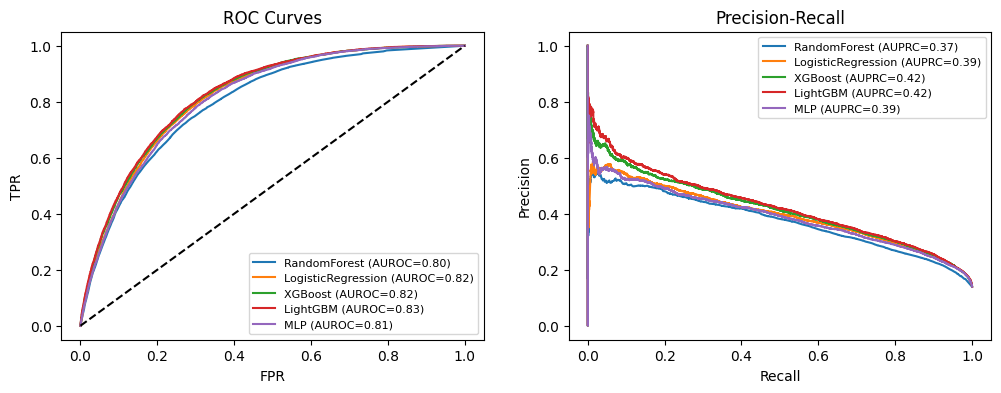

In [ ]:
# trained_pipelines = None
# baseline_metrics = None
# baseline_probas = None
# fi_df = None
# reduced_trained = None
# reduced_metrics = None
# selected_indices = None
fig, axes = plt.subplots(1,2, figsize=(12,4))
for name, y_proba in baseline_probas.items():
    try:
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        axes[0].plot(fpr, tpr, label=f"{name} (AUROC={baseline_metrics.loc[name,'AUROC']:.2f})")
    except Exception:
        pass
    try:
        precision, recall, _ = precision_recall_curve(y_test, y_proba)
        pr_auc = average_precision_score(y_test, y_proba)
        axes[1].plot(recall, precision, label=f"{name} (AUPRC={pr_auc:.2f})")
    except Exception:
        pass
axes[0].plot([0,1],[0,1],"k--")
axes[0].set_xlabel("FPR"); axes[0].set_ylabel("TPR"); axes[0].set_title("ROC Curves")
axes[1].set_xlabel("Recall"); axes[1].set_ylabel("Precision"); axes[1].set_title("Precision-Recall")
axes[0].legend(fontsize=8); axes[1].legend(fontsize=8)
plt.show()

     feature  importance  cum_importance
0        BMI    0.183293        0.183293
1        Age    0.122749        0.306042
2     Income    0.097808        0.403850
3   PhysHlth    0.084281        0.488131
4    GenHlth    0.070742        0.558873
5  Education    0.070241        0.629114
6   MentHlth    0.064212        0.693326
7     HighBP    0.043548        0.736874
8     Smoker    0.033045        0.769919
9     Fruits    0.033024        0.802943


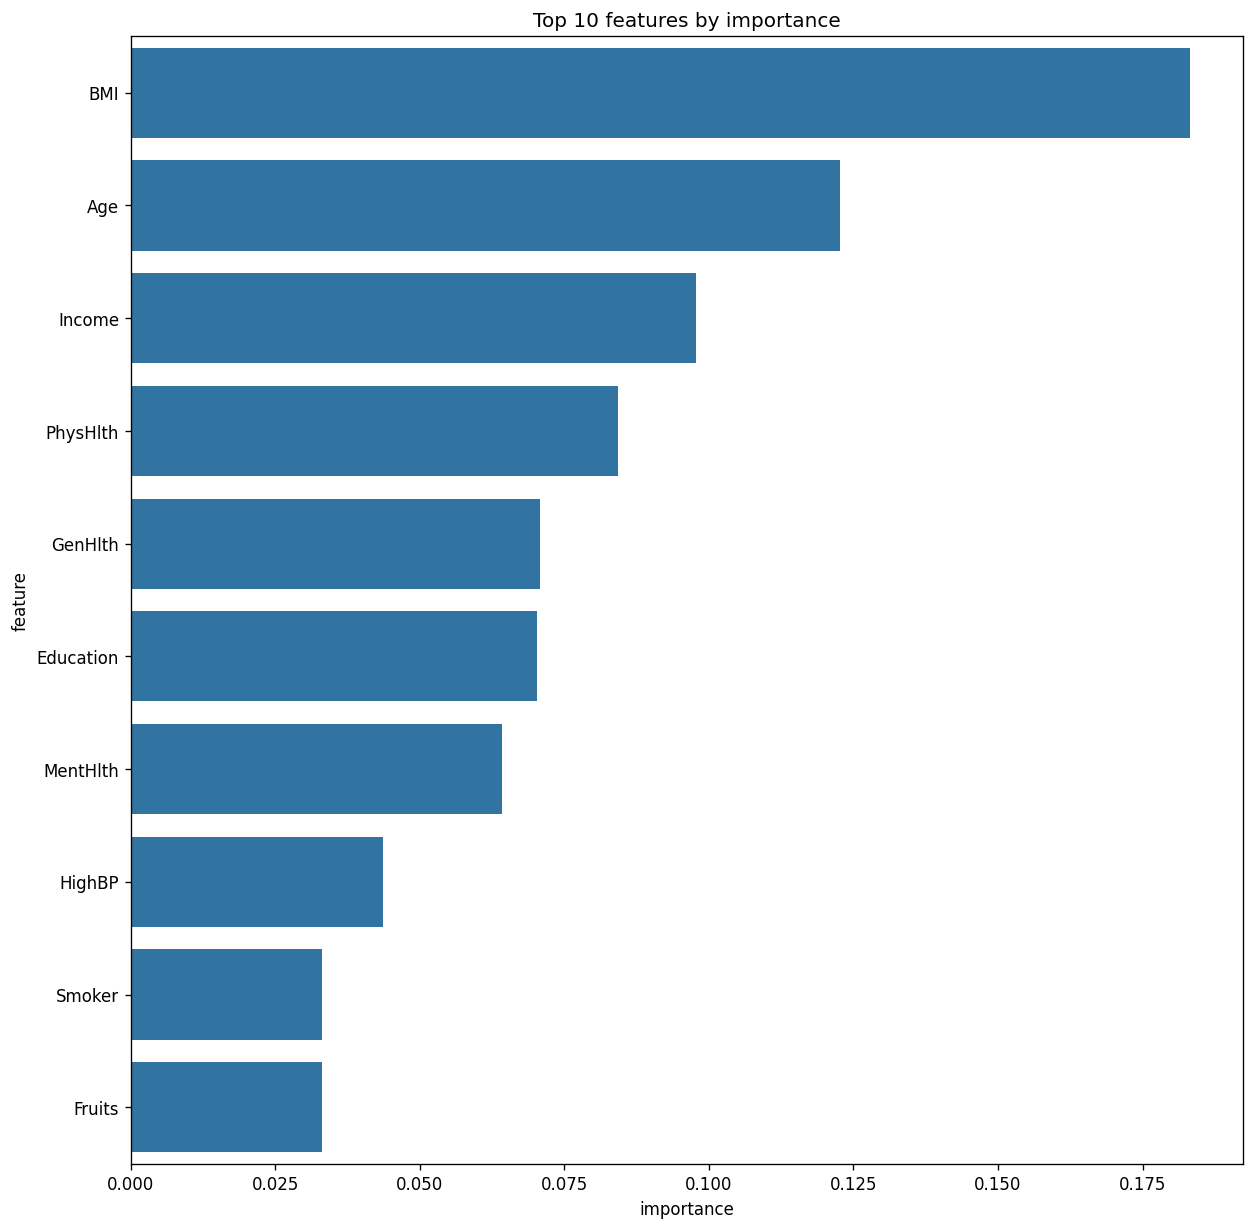

In [ ]:
fi_show = fi_df.copy()
print(fi_show.head(10))
# bar plot
# plt.figure(figsize=(8,8))
# plt.subplot(1, 2, 1)
plt.rcParams['figure.dpi'] = 120  # or higher = smaller appearance
fig, ax = plt.subplots(figsize=(10,10))
plt.tight_layout()
sns.barplot(data=fi_show.head(10), x="importance", y="feature", ax=ax)
ax.set_title("Top 10 features by importance")
plt.show()

In [ ]:
threshold = fi_threshold
selected = fi_df[fi_df["importance"] > threshold]["feature"].tolist()
print(f"Selected features above threshold ({threshold}): {len(selected)} features")
# map selected features back to indices in transformed array
selected_indices = [i for i, f in enumerate(feature_names) if f in selected]
selected_indices = selected_indices

# if len(selected_indices) == 0:
#     st.warning("No features selected with this threshold. Lower the threshold.")
# else:
#     # retrain reduced models (on transformed arrays)
#     with st.spinner("Retraining models on reduced feature set..."):
reduced_trained, reduced_metrics = retrain_on_selected(X_train_trans, X_test_trans, selected_indices, y_train, y_test, base_models)
reduced_trained = reduced_trained
reduced_metrics = reduced_metrics
    # st.success("Retrained on reduced feature set.")

# # Show reduced metrics if available
# if reduced_metrics is not None:
#     print("### Reduced-feature model performance")
print(reduced_metrics.round(4))

2025-11-07 01:07:15.418 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-07 01:07:15.419 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-07 01:07:15.420 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


[LightGBM] [Info] Number of positive: 28277, number of negative: 174667
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005461 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 208
[LightGBM] [Info] Number of data points in the train set: 202944, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.139334 -> initscore=-1.820833
[LightGBM] [Info] Start training from score -1.820833
                    Precision  Recall      F1   AUROC   AUPRC
RandomForest           0.4812  0.1737  0.2553  0.7942  0.3664
LogisticRegression     0.5184  0.1535  0.2368  0.8164  0.3909
XGBoost                0.5371  0.1669  0.2547  0.8205  0.4091
LightGBM               0.5669  0.1601  0.2497  0.8242  0.4213
MLP                    0.5118  0.1716  0.2570  0.8115  0.3921


### Similar-patient insights & digital twin simulation
Selected test-set patient index: 0 (0..50735)
Top similar patient indices (test-set indices) and similarity %:
   test_idx  similarity_pct
0     44852          99.957
1     10308          99.957
2     42622          99.954
3     19716          99.949
4     14211          99.944
Baseline predicted probabilities (selected patient):
{'RandomForest': 0.053, 'LogisticRegression': 0.15379378415780154, 'XGBoost': 0.1552519053220749, 'LightGBM': 0.1342436565503537, 'MLP': 0.1567832161147737}
Predicted probabilities for similar patients (before -> after intervention):
   test_idx  similarity_pct  RandomForest_before  RandomForest_after  \
0     44852          99.957               0.4401              0.2413   
1     10308          99.957               0.4645              0.5478   
2     42622          99.954               0.1257              0.7453   
3     19716          99.949               0.1100              0.0600   
4     14211        

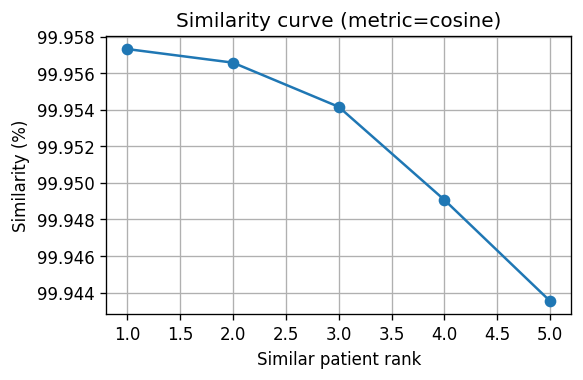

In [ ]:
print("### Similar-patient insights & digital twin simulation")
if trained_pipelines is None:
    print("Train models first")
else:
    # ensure patient_idx valid
    max_idx = X_test.shape[0]-1
    patient_idx = min(max(0, int(patient_idx)), max_idx)
    print(f"Selected test-set patient index: {patient_idx} (0..{max_idx})")

    # choose which trained pipelines to use for predictions
    trained = trained_pipelines
    # similarity space
    X_sim_space = X_test_mm  # min-max scaled transformed test set

    if run_similarity:
        # compute top-k similar
        top_idx, top_sims = get_similar_indices(X_sim_space, patient_idx, metric=sim_metric, top_k=top_k)
        print("Top similar patient indices (test-set indices) and similarity %:")
        sim_df = pd.DataFrame({"test_idx": top_idx, "similarity_pct": np.round(top_sims,3)})
        print(sim_df)

        # baseline probs for selected patient
        patient_row = X_test.iloc[[patient_idx]]
        baseline_probs = {}
        for name, pipe in trained.items():
            if hasattr(pipe.named_steps['clf'], "predict_proba"):
                baseline_probs[name] = float(pipe.predict_proba(patient_row)[0,1])
            else:
                baseline_probs[name] = float(pipe.predict(patient_row)[0])
        print("Baseline predicted probabilities (selected patient):")
        print(baseline_probs)

        # for each similar patient, compute prob before/after intervention for each model
        rows = []
        for idx, sim_pct in zip(top_idx, top_sims):
            sim_row = X_test.iloc[[idx]]
            info = {"test_idx": int(idx), "similarity_pct": float(np.round(sim_pct,3))}
            for name, pipe in trained.items():
                if hasattr(pipe.named_steps['clf'], "predict_proba"):
                    prob_before = float(pipe.predict_proba(sim_row)[0,1])
                else:
                    prob_before = float(pipe.predict(sim_row)[0])
                sim_after_row = apply_intervention(sim_row.iloc[0], bmi_delta=bmi_delta, set_phys_active=set_phys_active).to_frame().T
                if hasattr(pipe.named_steps['clf'], "predict_proba"):
                    prob_after = float(pipe.predict_proba(sim_after_row)[0,1])
                else:
                    prob_after = float(pipe.predict(sim_after_row)[0])
                info[f"{name}_before"] = round(prob_before,4)
                info[f"{name}_after"] = round(prob_after,4)
                info[f"{name}_delta"] = round(prob_before - prob_after,4)
            rows.append(info)
        result_df = pd.DataFrame(rows)
        print("Predicted probabilities for similar patients (before -> after intervention):")
        print(result_df)

        # average improvement per model
        avg_imp = {}
        for name in trained.keys():
            avg_imp[name] = float(result_df[f"{name}_delta"].mean())
        print("Average risk reduction across top-K similar patients (prob_before - prob_after):")
        print(avg_imp)

        # plot similarity curve (top PLOT_TOP_N)
        plot_n = min(len(top_sims),  min(10, PLOT_TOP_N))
        fig, ax = plt.subplots(figsize=(5,3))
        ax.plot(np.arange(1, len(top_sims)+1), top_sims, marker='o')
        ax.set_xlabel("Similar patient rank")
        ax.set_ylabel("Similarity (%)")
        ax.set_title(f"Similarity curve (metric={sim_metric})")
        ax.grid(True)
        plt.show()

    else:
        print("Click 'Run similarity insights' in the sidebar to compute similar patients and interventions.")
